# StatFin25 Workshop

## Financial Statistics using Julia

### 16-17th Dec, 2025

#### Instructor: Sourish

# **Portfolio Optimization**

- Markowitz’s Portfolio Optimization (1952) minimizes the portfolio variance for a given level of expected return:

$$
\min_{\omega} \; \omega^\top \Sigma \, \omega
$$

subject to

$$
\omega^\top \mu = \mu_0,
$$

where $\mu_0$ is the target (required) expected return.

---

- Note that you must provide the covariance matrix $\Sigma$.
- In practice, the true $\Sigma$ is unknown.
- Therefore, we **estimate** $\Sigma$ from data.

A common estimator (sample covariance matrix) is:

$$
S = \frac{1}{n-1} \sum_{i=1}^n (r_i - \bar{r})(r_i - \bar{r})^\top.
$$

- Other estimators (e.g., Bayesian shrinkage estimators) can also be used, and each produces a **different efficient frontier**.

- In **R**, you may compute Markowitz portfolios using  
  `portfolio.optim()` from the `tseries` package.

---

## **Example Setup**

- Suppose you construct a **global portfolio** with a passive investment strategy, investing in indices similar to FTSE, DAX, SMI, and CAC.
- Your annualized expected return is **12.5%**.
- Assume the annualized risk-free rate is **3%**.



In [1]:
using CSV, DataFrames, Statistics, LinearAlgebra, JuMP, OSQP, Plots

# ----------------------------------------------------------
# Load EuStockMarkets dataset
# ----------------------------------------------------------
url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/EuStockMarkets.csv"
df = CSV.read(download(url), DataFrame)

# Extract 4 index columns (DAX, SMI, CAC, FTSE)

Index_Value = Matrix(select(df, [:DAX, :SMI, :CAC, :FTSE]))

# ----------------------------------------------------------
# Compute log-returns (%)
# ----------------------------------------------------------
r = diff(log.(Index_Value); dims=1) .* 100
(T_minus1, n_assets) = size(r)

# ----------------------------------------------------------
# Expected return target (12.5% annually → daily)
# ----------------------------------------------------------
expected_return = 12.5/252        # same as R

# Risk-free rate (annual 3%)
rf = 3/252

# ----------------------------------------------------------
# Covariance matrix of returns
# ----------------------------------------------------------
Σ = cov(r)

# Mean returns (per day)
μ = vec(mean(r; dims=1))



4-element Vector{Float64}:
 0.0652041747691327
 0.0817899655305225
 0.043705398690016634
 0.04319850766495749

In [2]:
# ----------------------------------------------------------
# Markowitz optimisation: min w'Σw
# s.t. sum(w) = 1, μ'w ≥ target, w ≥ 0
# ----------------------------------------------------------
model = Model(OSQP.Optimizer)

@variable(model, w[1:n_assets] >= 0)       # long-only weights
@constraint(model, sum(w) == 1)            # fully invested
@constraint(model, μ' * w == expected_return)

@objective(model, Min, w' * Σ * w)

optimize!(model)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4, constraints m = 6
          nnz(P) + nnz(A) = 22
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   2.30e+02   1.00e-01   2.26e-05s
  25   5.8247e-01   2.22e-04   9.89e-04   1.00e-01   2.82e-05s

status:               solved
number of iterations

In [3]:
w_opt = value.(w)

println("\nOptimised portfolio weights (fraction of wealth):")
println(w_opt)

println("\nOptimised weights in %:")
weights_percent = round.(w_opt .* 100, digits = 3)
println(weights_percent)


Optimised portfolio weights (fraction of wealth):
[-0.0001511048182233516, 0.16557810846712262, 0.02716505456448603, 0.8071860700520205]

Optimised weights in %:
[-0.015, 16.558, 2.717, 80.719]


In [4]:
# Check implied portfolio stats
μ_p = dot(μ, w_opt)
σ_p = sqrt(w_opt' * Σ * w_opt)

println("\nPortfolio expected daily return ≈ ", μ_p)
println("Portfolio daily volatility         ≈ ", σ_p)


Portfolio expected daily return ≈ 0.04958926829352522
Portfolio daily volatility         ≈ 0.7631957955529797


### Find the efficient frontier

In [5]:
# ----------------------------------------------------------
# Inputs (already computed earlier)
# r      : T × N matrix of log-returns (DECIMAL, not %)
# μ      : N × 1 vector of mean returns
# Σ      : N × N covariance matrix
# ----------------------------------------------------------

μ = vec(mean(r; dims = 1))
Σ = cov(r)

n_assets = length(μ)
println(μ)
Σ

[0.0652041747691327, 0.0817899655305225, 0.043705398690016634, 0.04319850766495749]


4×4 Matrix{Float64}:
 1.06107   0.669956  0.834513  0.524179
 0.669956  0.855632  0.628588  0.430452
 0.834513  0.628588  1.2168    0.569317
 0.524179  0.430452  0.569317  0.633254

In [6]:
# Target expected returns 
er = collect(0.045:0.001:0.075) #./ 252   # annual → daily
n_er = length(er)

frontier = zeros(n_er, 2)   # [volatility, expected return]

#for (i, μ_target) in enumerate(er)
#    print(i,"  ",μ_target,"\n")
#end

# ----------------------------------------------------------
# Loop over target returns
# ----------------------------------------------------------
for (i, μ_target) in enumerate(er)

    model = Model(OSQP.Optimizer)
    set_silent(model)

    @variable(model, w[1:n_assets] >= 0)      # long-only
    @constraint(model, sum(w) == 1)
    @constraint(model, μ' * w == μ_target)

    @objective(model, Min, w' * Σ * w)

    optimize!(model)

    w_opt = value.(w)

    # portfolio volatility and return
    σ_p = sqrt(w_opt' * Σ * w_opt)
    μ_p = dot(μ, w_opt)

    frontier[i, :] .= [σ_p, μ_p]
end


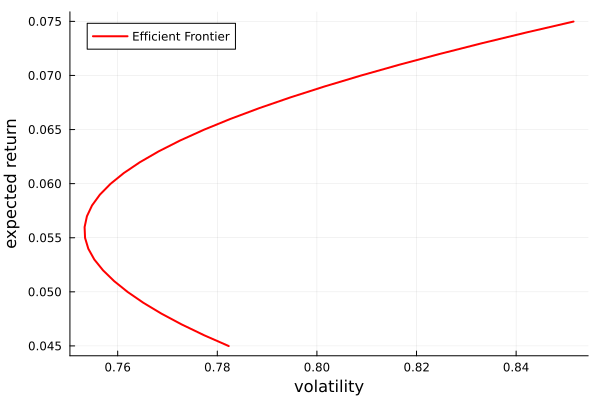

In [7]:
# ----------------------------------------------------------
# Plot efficient frontier
# ----------------------------------------------------------
plot(
    frontier[:, 1], frontier[:, 2],
    lw = 2,
    color = :red,
    xlabel = "volatility",
    ylabel = "expected return",
    label = "Efficient Frontier",
    grid = :on
)
